In [4]:
import utils_general
import utils_CMIP
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import xarray as xr
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # Use a LaTeX-compatible serif font
    "font.serif": ["Computer Modern Roman"],  # Or another LaTeX font
})

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Experiment 5: CMIP6
### Model: MPI-ESM1-2-LR

In [2]:
path_to_cmip6_data = '/Volumes/PRO-G40/data/raw/CMIP6'
model = 'MPI-ESM1-2-LR'
realization = 'r1i1p1f1'
piCtrl = 'piControl'
experiment = '1pctCO2'

ERF_vars = ['rlut','rsdt','rsut']

spatial_res = '250_km'
temporal_res = 'mon'

### Import piControl data

In [6]:
tas_piCtrl_ds_path = f'{path_to_cmip6_data}/{model}/{realization}/{piCtrl}/tas/{spatial_res}/{temporal_res}/*/*.nc'
tas_global_climatology_ds = utils_CMIP.import_calc_climatology(tas_piCtrl_ds_path, 'tas', global_mean=True)

rlut_piCtrl_ds_path = f'{path_to_cmip6_data}/{model}/{realization}/{piCtrl}/rlut/{spatial_res}/{temporal_res}/*/*.nc'
rlut_global_climatology_ds = utils_CMIP.import_calc_climatology(rlut_piCtrl_ds_path, 'rlut', global_mean=True)

rsdt_piCtrl_ds_path = f'{path_to_cmip6_data}/{model}/{realization}/{piCtrl}/rsdt/{spatial_res}/{temporal_res}/*/*.nc'
rsdt_global_climatology_ds = utils_CMIP.import_calc_climatology(rsdt_piCtrl_ds_path, 'rsdt', global_mean=True)

rsut_piCtrl_ds_path = f'{path_to_cmip6_data}/{model}/{realization}/{piCtrl}/rsut/{spatial_res}/{temporal_res}/*/*.nc'
rsut_global_climatology_ds = utils_CMIP.import_calc_climatology(rsut_piCtrl_ds_path, 'rsut', global_mean=True)

### Import 1pctCO2 data

In [7]:
tas_1pct_ds_path = f'{path_to_cmip6_data}/{model}/{realization}/{experiment}/tas/{spatial_res}/{temporal_res}/*/*.nc'
tas_global_1pct_annual_ds = utils_CMIP.import_annual(tas_1pct_ds_path, 'tas', global_mean=True)

rlut_1pct_ds_path = f'{path_to_cmip6_data}/{model}/{realization}/{experiment}/rlut/{spatial_res}/{temporal_res}/*/*.nc'
rlut_global_1pct_annual_ds = utils_CMIP.import_annual(rlut_1pct_ds_path, 'rlut', global_mean=True)

rsdt_1pct_ds_path = f'{path_to_cmip6_data}/{model}/{realization}/{experiment}/rsdt/{spatial_res}/{temporal_res}/*/*.nc'
rsdt_global_1pct_annual_ds = utils_CMIP.import_annual(rsdt_1pct_ds_path, 'rsdt', global_mean=True)

rsut_1pct_ds_path = f'{path_to_cmip6_data}/{model}/{realization}/{experiment}/rsut/{spatial_res}/{temporal_res}/*/*.nc'
rsut_global_1pct_annual_ds = utils_CMIP.import_annual(rsut_1pct_ds_path, 'rsut', global_mean=True)

### Calculate ERF

In [8]:
lam = 1.20
ERF_climatology_ds = utils_CMIP.calc_ERF(tas_global_climatology_ds, rlut_global_climatology_ds,
                                         rsdt_global_climatology_ds, rsut_global_climatology_ds, lam)

ERF_1pct_global_annual_ds = utils_CMIP.calc_ERF(tas_global_1pct_annual_ds, rlut_global_1pct_annual_ds,
                                                rsdt_global_1pct_annual_ds, rsut_global_1pct_annual_ds, lam)

### Calculate anomalies

In [9]:
tas_1pct_global_anomaly_1pct_annual_ds = tas_global_1pct_annual_ds - tas_global_climatology_ds
ERF_1pct_global_anomaly_1pct_annual_ds = ERF_1pct_global_annual_ds - ERF_climatology_ds

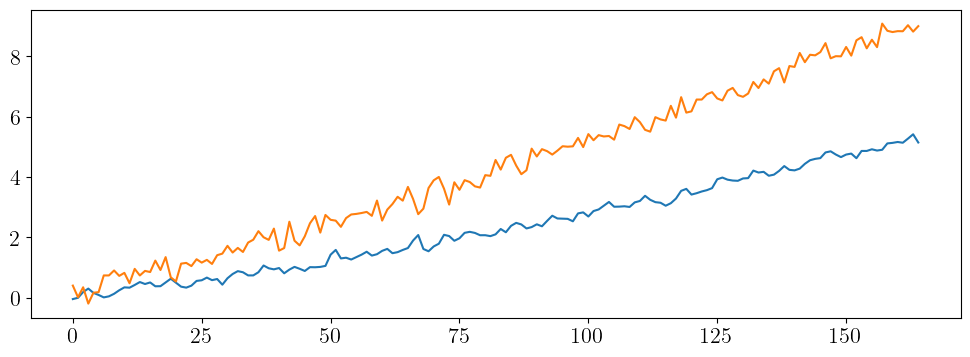

In [10]:
plt.plot(tas_1pct_global_anomaly_1pct_annual_ds)
plt.plot(ERF_1pct_global_anomaly_1pct_annual_ds)

In [11]:
T = tas_1pct_global_anomaly_1pct_annual_ds.values
F = ERF_1pct_global_anomaly_1pct_annual_ds.values
g, a = utils_general.calc_modes(T)
t = tas_1pct_global_anomaly_1pct_annual_ds.time.values

## Global Data

#### Method 1: Using 4xCO2 experiment as impulse?

#### Method 2: Direct inference of L from a dataset

5.143247890253341


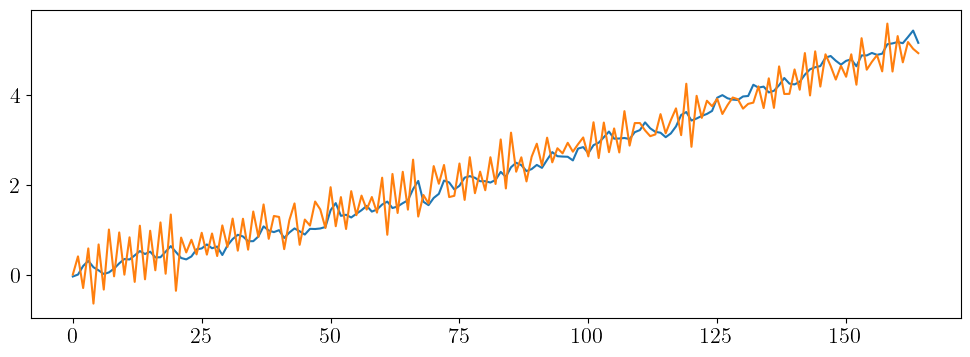

In [12]:
L = utils_general.calc_L_direct_1D(T, F, t, (0,len(t)), 1, 1, modal=False, g=None)
T_est_raw = utils_general.reconstruct_T(F, 1, t, L, 0, 1)

print(np.linalg.norm(T - T_est_raw))
plt.plot(tas_1pct_global_anomaly_1pct_annual_ds)
plt.plot(T_est_raw)

#### Method 3: Deconvolution

0.0007183731389983079


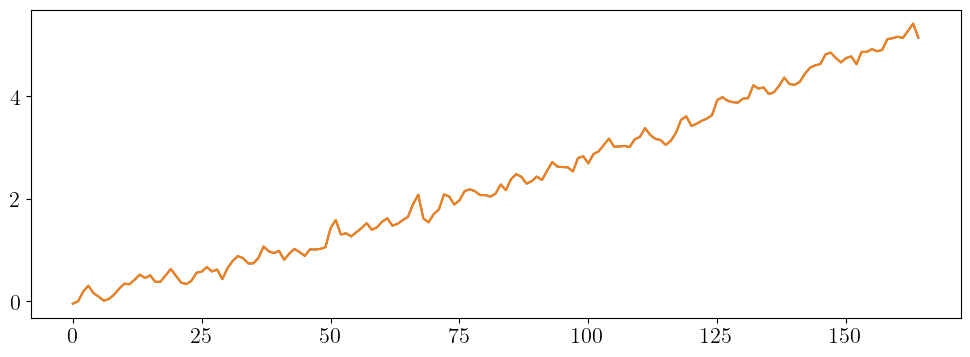

In [49]:
from scipy.linalg import toeplitz
G_deconv = utils_general.calc_G_deconv_2D(T, F, dt=1)

F_toeplitz = toeplitz(F, np.zeros_like(F))
T_est_deconv = (G_deconv) @ F_toeplitz.T

print(np.linalg.norm(T - T_est_deconv))
plt.plot(tas_1pct_global_anomaly_1pct_annual_ds)
plt.plot(T_est_deconv)

#### Method 4: Best fit

In [81]:
from scipy.optimize import minimize
initial_guess = np.array([1, 1])
t_range = np.arange(t[-1] - t[0] + 1)
res_raw = minimize(utils_general.opt_h_lam_1D,
                                  initial_guess,
                                  args=(T, F, t_range, 1))

G_fit = utils_general.apply_response_1D(res_raw.x, t_range)

1.5075891054932022


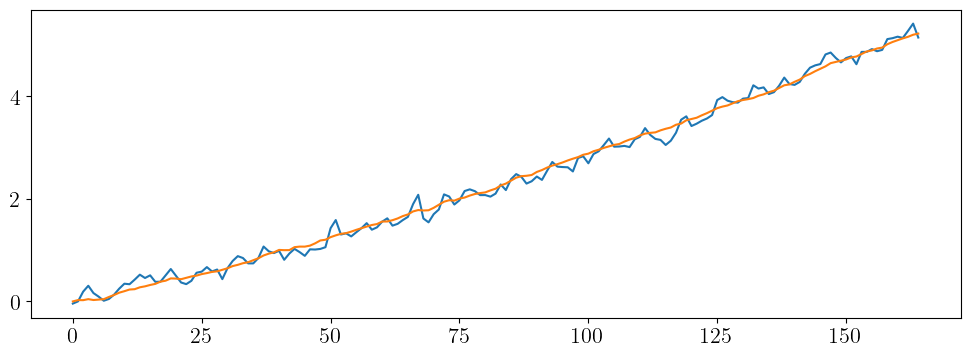

In [84]:
T_est_fit = (G_fit) @ F_toeplitz.T
print(np.linalg.norm(T - T_est_fit))
plt.plot(tas_1pct_global_anomaly_1pct_annual_ds)
plt.plot(T_est_fit.T)

## Spatial Data